In [1]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 3.3 MB 34.4 MB/s 
     |████████████████████████████████| 596 kB 40.9 MB/s 
     |████████████████████████████████| 895 kB 33.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.nn.functional as F
import torch.optim as optim
import transformers
from transformers import AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_curve = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# # define the model parameter
batch_size = 2
epoches = 100
model = "bert-base-uncased"
hidden_size = 768
n_class = 2
maxlen = 8

encode_layer=12
filter_sizes = [2, 2, 2]
num_filters = 3

In [4]:
# data，构造一些训练数据
# sentences = ["我喜欢打篮球", "这个相机很好看", "今天玩的特别开心", "我不喜欢你", "太糟糕了", "真是件令人伤心的事情"]
# labels = [1, 1, 1, 0, 0, 0]  # 1 crime news, 0 nocrime news.

In [5]:
# Load Dataset

In [6]:
df = pd.read_csv("label_news.csv")
df.head()

,Unnamed: 0,news_cl,Body,label
0,0,"{ ""_index"" : ""base_operations_news_index"", ...","""Chicagou2019s police oversight agency release...",1
1,1,"{ ""_index"" : ""base_operations_news_index"", ...","""Filed under:"", ""One person was fat...",1
2,2,"{ ""_index"" : ""base_operations_news_index"", ...","""Filed under:"", ""The dayu2019s fata...",1
3,3,"{ ""_index"" : ""base_operations_news_index"", ...","""Filed under:"", ""A woman was fatall...",1
4,4,"{ ""_index"" : ""base_operations_news_index"", ...","""Filed under:"", ""The fatal shooting...",1


In [7]:
df= df[['label', 'Body']]
df.columns=['label', 'text']
df.head()

,label,text
0,1,"""Chicagou2019s police oversight agency release..."
1,1,"""Filed under:"", ""One person was fat..."
2,1,"""Filed under:"", ""The dayu2019s fata..."
3,1,"""Filed under:"", ""A woman was fatall..."
4,1,"""Filed under:"", ""The fatal shooting..."


In [8]:
# check class distribution
df['label'].value_counts(normalize = True)

1    0.789916
0    0.210084
Name: label, dtype: float64

In [9]:
df.shape

(119, 2)

In [24]:
# Split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [11]:
sentences = train_text.to_list()

In [12]:
labels = train_labels.to_list()

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[1|100] step:1/42 loss:0.7760
[1|100] step:2/42 loss:0.3174
[1|100] step:3/42 loss:3.8641
[1|100] step:4/42 loss:2.8095
[1|100] step:5/42 loss:0.7293
[1|100] step:6/42 loss:0.6963
[1|100] step:7/42 loss:1.6211
[1|100] step:8/42 loss:2.7493
[1|100] step:9/42 loss:1.7013
[1|100] step:10/42 loss:0.5347
[1|100] step:11/42 loss:0.9064
[1|100] step:12/42 loss:0.2473
[1|100] step:13/42 loss:0.1959
[1|100] step:14/42 loss:1.1069
[1|100] step:15/42 loss:1.0550
[1|100] step:16/42 loss:0.9358
[1|100] step:17/42 loss:0.3896
[1|100] step:18/42 loss:0.7357
[1|100] step:19/42 loss:0.7037
[1|100] step:20/42 loss:0.7123
[1|100] step:21/42 loss:0.5704
[1|100] step:22/42 loss:0.3737
[1|100] step:23/42 loss:0.2418
[1|100] step:24/42 loss:1.0568
[1|100] step:25/42 loss:0.1278
[1|100] step:26/42 loss:0.1061
[1|100] step:27/42 loss:1.2764
[1|100] step:28/42 loss:0.0911
[1|100] step:29/42 loss:0.0898
[1|100] step:30/42 loss:0.0858
[1|100] step:31/42 loss:0.0797
[1|100] step:32/42 loss:0.0723
[1|100] step:33/4

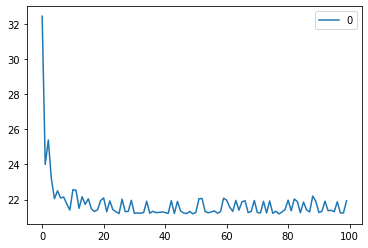

In [13]:


class MyDataset(Data.Dataset):
  def __init__(self, sentences, labels=None, with_labels=True,):
    self.tokenizer = AutoTokenizer.from_pretrained(model)
    self.with_labels = with_labels
    self.sentences = sentences
    self.labels = labels
  def __len__(self):
    return len(sentences)

  def __getitem__(self, index):
    # Selecting sentence1 and sentence2 at the specified index in the data frame
    sent = self.sentences[index]

    # Tokenize the pair of sentences to get token ids, attention masks and token type ids
    encoded_pair = self.tokenizer(sent,
                    padding='max_length',  # Pad to max_length
                    truncation=True,       # Truncate to max_length
                    max_length=maxlen,  
                    return_tensors='pt')  # Return torch.Tensor objects

    token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
    attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
    token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

    if self.with_labels:  # True if the dataset has labels
      label = self.labels[index]
      return token_ids, attn_masks, token_type_ids, label
    else:
      return token_ids, attn_masks, token_type_ids

train = Data.DataLoader(dataset=MyDataset(sentences, labels), batch_size=batch_size, shuffle=True, num_workers=1)

class TextCNN(nn.Module):
  def __init__(self):
    super(TextCNN, self).__init__()
    self.num_filter_total = num_filters * len(filter_sizes)
    self.Weight = nn.Linear(self.num_filter_total, n_class, bias=False)
    self.bias = nn.Parameter(torch.ones([n_class]))
    self.filter_list = nn.ModuleList([
      nn.Conv2d(1, num_filters, kernel_size=(size, hidden_size)) for size in filter_sizes
    ])

  def forward(self, x):
    # x: [bs, seq, hidden]
    x = x.unsqueeze(1) # [bs, channel=1, seq, hidden]
    
    pooled_outputs = []
    for i, conv in enumerate(self.filter_list):
      h = F.relu(conv(x)) # [bs, channel=1, seq-kernel_size+1, 1]
      mp = nn.MaxPool2d(
        kernel_size = (encode_layer-filter_sizes[i]+1, 1)
      )
      # mp: [bs, channel=3, w, h]
      pooled = mp(h).permute(0, 3, 2, 1) # [bs, h=1, w=1, channel=3]
      pooled_outputs.append(pooled)
    
    h_pool = torch.cat(pooled_outputs, len(filter_sizes)) # [bs, h=1, w=1, channel=3 * 3]
    h_pool_flat = torch.reshape(h_pool, [-1, self.num_filter_total])
    
    output = self.Weight(h_pool_flat) + self.bias # [bs, n_class]

    return output

# model
class Bert_Blend_CNN(nn.Module):
  def __init__(self):
    super(Bert_Blend_CNN, self).__init__()
    self.bert = AutoModel.from_pretrained(model, output_hidden_states=True, return_dict=True)
    self.linear = nn.Linear(hidden_size, n_class)
    self.textcnn = TextCNN()
    
  def forward(self, X):
    input_ids, attention_mask, token_type_ids = X[0], X[1], X[2]
    outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids) # return a output dict
    # get the vector of the encode in every layers
    # outputs.pooler_output: [bs, hidden_size]
    hidden_states = outputs.hidden_states # 13*[bs, seq_len, hidden] the first embedding layer
    cls_embeddings = hidden_states[1][:, 0, :].unsqueeze(1) # [bs, 1, hidden] # the first token(cls vector) is extracted，combine together and take as textcnn's input
    for i in range(2, 13):
      cls_embeddings = torch.cat((cls_embeddings, hidden_states[i][:, 0, :].unsqueeze(1)), dim=1)
    # cls_embeddings: [bs, encode_layer=12, hidden]
    logits = self.textcnn(cls_embeddings)
    return logits

bert_blend_cnn = Bert_Blend_CNN().to(device)

optimizer = optim.Adam(bert_blend_cnn.parameters(), lr=1e-3, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

# train
sum_loss = 0
total_step = len(train)
for epoch in range(epoches):
  for i, batch in enumerate(train):
    optimizer.zero_grad()
    batch = tuple(p.to(device) for p in batch)
    pred = bert_blend_cnn([batch[0], batch[1], batch[2]])
    loss = loss_fn(pred, batch[3])
    sum_loss += loss.item()

    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
      print('[{}|{}] step:{}/{} loss:{:.4f}'.format(epoch+1, epoches, i+1, total_step, loss.item()))
  train_curve.append(sum_loss)
  sum_loss = 0


pd.DataFrame(train_curve).plot() # loss curve line

In [14]:
# sentences = val_text
# labels =val_labels

In [25]:
test_text

4      "Filed under:",            "The fatal shooting...
98     "Filed under:",            "A 16-count indictm...
86     "Filed under:",            "A teenager faces o...
81     "Filed under:",            "Officers received ...
34     "Filed under:",            "The 32-year-old ma...
78     "Filed under:",            "One officer suffer...
29     "Filed under:",            "A 15-year-old boy ...
50     "Filed under:",            "Todayu2019s update...
83     "Filed under:",            "Tommie Brown, 30, ...
26     "Filed under:",            "A sedan struck two...
97     "Filed under:",            "The proposed repea...
10     "Filed under:",            "A woman was killed...
118    "Filed under:",            "Robert Rodat, nomi...
68     "Filed under:",            "About 1:45 p.m., a...
93     "Filed under:",            "Two men were stand...
116    "Filed under:",            "About 10:30 a.m., ...
112    "Filed under:",            "The mandate comes ...
6      "Filed under:",         

In [27]:
test_labels

4      1
98     1
86     1
81     1
34     1
78     1
29     1
50     0
83     1
26     1
97     0
10     1
118    0
68     1
93     1
116    1
112    0
6      1
Name: label, dtype: int64

In [33]:
# test
bert_blend_cnn.eval()
with torch.no_grad():
  test_text1 = [test_text.to_list()[10]]
  test_labels1 = [test_labels .to_list()[10]]
  test = MyDataset(test_text1, labels=None, with_labels=False)
  x = test.__getitem__(0)
  x = tuple(p.unsqueeze(0).to(device) for p in x)
  pred = bert_blend_cnn([x[0], x[1], x[2]])
  pred = pred.data.max(dim=1, keepdim=True)[1]
  if pred[0][0] == 0:
    print('nocrime news')
    print('real label: ', test_labels1[0])
  else:
    print('crime news')
    print('real label: ', test_labels1[0])


crime news
real label:  0


In [34]:
# test
bert_blend_cnn.eval()
with torch.no_grad():
  test_text1 = [test_text.to_list()[5]]
  test_labels1 = [test_labels .to_list()[5]]
  test = MyDataset(test_text1, labels=None, with_labels=False)
  x = test.__getitem__(0)
  x = tuple(p.unsqueeze(0).to(device) for p in x)
  pred = bert_blend_cnn([x[0], x[1], x[2]])
  pred = pred.data.max(dim=1, keepdim=True)[1]
  if pred[0][0] == 0:
    print('nocrime news')
    print('real label: ', test_labels1[0])
  else:
    print('crime news')
    print('real label: ', test_labels1[0])

crime news
real label:  1
